<a href="https://colab.research.google.com/github/C22-PS001-Capstone/Vee-ML-Deployment/blob/main/Forecast_V1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [30]:
import numpy as np
import pandas as pd
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import tensorflow as tf
import pathlib
import copy
import math

In [31]:
print(tf.__version__)

2.8.2


In [32]:
# get data from github
! wget -c 'https://raw.githubusercontent.com/C22-PS001-Capstone/Vee-ML-Deployment/main/dataset/data.csv' 'data.csv'

--2022-06-06 12:36:34--  https://raw.githubusercontent.com/C22-PS001-Capstone/Vee-Machine-Learning/main/data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 416 Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

--2022-06-06 12:36:34--  http://data.csv/
Resolving data.csv (data.csv)... failed: Name or service not known.
wget: unable to resolve host address ‘data.csv’


In [33]:
raw_data = pd.read_csv("data.csv")
raw_data.head()

,date,cost
0,2019-01-06,305350
1,2019-01-10,325050
2,2019-01-11,285650
3,2019-01-16,315200
4,2019-01-22,256100


In [34]:
raw_data.tail()

,date,cost
264,2021-12-16,243000
265,2021-12-23,234000
266,2021-12-26,261000
267,2021-12-29,288000
268,2021-12-31,243000


In [35]:
raw_data.isnull().sum()

date    0
cost    0
dtype: int64

In [36]:
# Fill missing data
idx = pd.date_range('01-01-2019', '31-12-2021')
data = copy.copy(raw_data)
data.index = pd.DatetimeIndex(data.date)
data = data.reindex(idx, fill_value=np.nan)
data.date = data.index
data = data.reset_index(drop=True)
data = data.bfill();
data

,date,cost
0,2019-01-01,305350.0
1,2019-01-02,305350.0
2,2019-01-03,305350.0
3,2019-01-04,305350.0
4,2019-01-05,305350.0
...,...,...
1091,2021-12-27,288000.0
1092,2021-12-28,288000.0
1093,2021-12-29,288000.0
1094,2021-12-30,243000.0


In [37]:
#data_train['cost'] = data_train['cost'].fillna(0).astype(int)
data_train = data
data_train['date'] = pd.to_datetime(data_train['date']).dt.strftime("%Y-%m-%d")
data_train

,date,cost
0,2019-01-01,305350.0
1,2019-01-02,305350.0
2,2019-01-03,305350.0
3,2019-01-04,305350.0
4,2019-01-05,305350.0
...,...,...
1091,2021-12-27,288000.0
1092,2021-12-28,288000.0
1093,2021-12-29,288000.0
1094,2021-12-30,243000.0


In [38]:
print(data_train.dtypes)

date     object
cost    float64
dtype: object


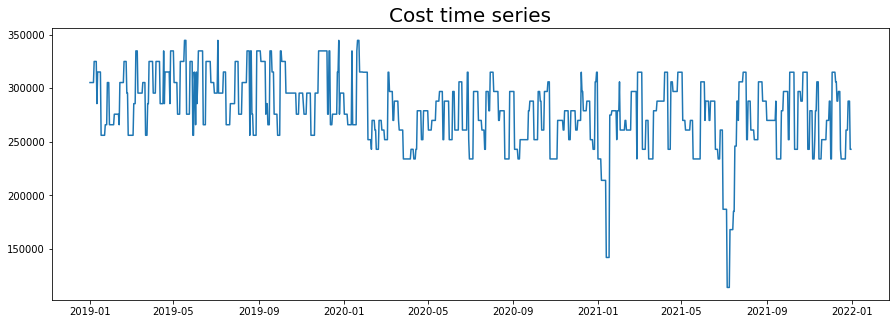

In [39]:
data_train['date'] = pd.to_datetime(data_train['date'].values)
data_train['cost']  = data_train['cost'].values.astype(np.float32)

plt.figure(figsize=(15,5))
plt.plot(data_train['date'], data_train['cost'], '-')
plt.title('Cost time series',
          fontsize=20);

# Train and Test Data

In [40]:
total_data = len(data_train)
trainPercentage = .8
trainMaxIndex = math.floor(total_data * trainPercentage)
trainMaxIndex

train_data = data_train[:trainMaxIndex]
train_time = train_data['date']
#scaling
train_cost = train_data['cost']/100000

test_data = data_train[trainMaxIndex:]
test_time = test_data['date']
#scaling
test_cost = test_data['cost']/100000

WINDOW_SIZE=20

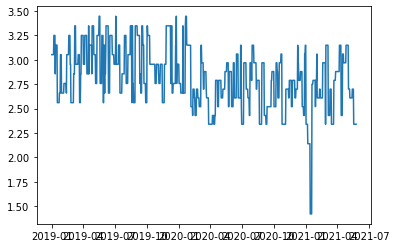

In [41]:
fig = plt.figure()  
plt.plot(train_time, train_cost, '-') 
plt.show() 

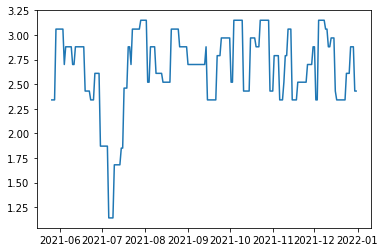

In [42]:
fig = plt.figure()  
plt.plot(test_time, test_cost, '-') 
plt.show() 

In [43]:
def ts_data_generator(data, window_size, batch_size, shuffle_buffer):
  '''
  Utility function for time series data generation in batches
  '''
  ts_data = tf.data.Dataset.from_tensor_slices(data)
  ts_data = ts_data.window(window_size + 1, shift=1, drop_remainder=True)
  ts_data = ts_data.flat_map(lambda window: window.batch(window_size + 1))
  ts_data = ts_data.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  ts_data = ts_data.batch(batch_size).prefetch(1)
  return ts_data

In [44]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

In [45]:
#train_set = windowed_dataset(train_cost, window_size=60, batch_size=100, shuffle_buffer=1000)
#test_set =  windowed_dataset(test_cost, window_size=60, batch_size=100, shuffle_buffer=1000)
train_set = ts_data_generator(train_cost, window_size=WINDOW_SIZE, batch_size=100, shuffle_buffer=1000)
test_set =  ts_data_generator(test_cost, window_size=WINDOW_SIZE, batch_size=100, shuffle_buffer=1000)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,strides=1, padding="causal",activation="relu",                       
    input_shape=[None, 1]),
  #tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60),
  tf.keras.layers.Dense(40),
  tf.keras.layers.Dropout(0.3),
  # tf.keras.layers.Dense(20),
  # tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(10),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(1),
])

In [46]:
optimizer = tf.keras.optimizers.SGD(learning_rate=1.0000e-03, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, 
                    validation_data=test_set,
                    epochs=50)
model.summary()

Epoch 1/50
9/9 [==============================] - 2s 71ms/step - loss: 1.9666 - mae: 2.4607 - val_loss: 0.9170 - val_mae: 1.4045
Epoch 2/50
9/9 [==============================] - 0s 14ms/step - loss: 0.8893 - mae: 1.3137 - val_loss: 0.0660 - val_mae: 0.2948
Epoch 3/50
9/9 [==============================] - 0s 13ms/step - loss: 0.7614 - mae: 1.1743 - val_loss: 0.0868 - val_mae: 0.3443
Epoch 4/50
9/9 [==============================] - 0s 16ms/step - loss: 0.6443 - mae: 1.0535 - val_loss: 0.2420 - val_mae: 0.6269
Epoch 5/50
9/9 [==============================] - 0s 13ms/step - loss: 0.5778 - mae: 0.9794 - val_loss: 0.1536 - val_mae: 0.4754
Epoch 6/50
9/9 [==============================] - 0s 17ms/step - loss: 0.4983 - mae: 0.8870 - val_loss: 0.0845 - val_mae: 0.3397
Epoch 7/50
9/9 [==============================] - 0s 15ms/step - loss: 0.5090 - mae: 0.8917 - val_loss: 0.0892 - val_mae: 0.3489
Epoch 8/50
9/9 [==============================] - 0s 14ms/step - loss: 0.5157 - mae: 0.9095 - val

Text(0.5, 0.98, 'Loss Vs Val Loss')

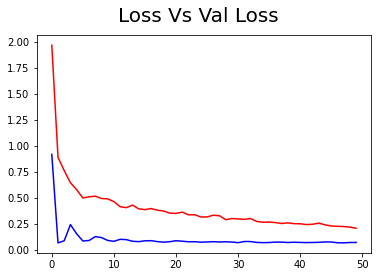

In [47]:
fig = plt.figure()
plt.plot(history.history['loss'], 'r', history.history['val_loss'], 'b')
fig.suptitle('Loss Vs Val Loss', fontsize=20)

Text(0.5, 0.98, 'MAE Vs Val MAE')

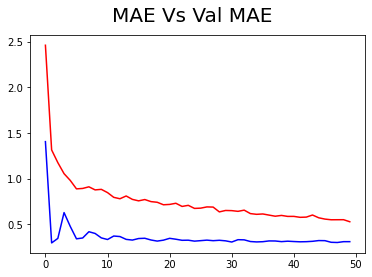

In [48]:
fig = plt.figure()
plt.plot(history.history['mae'], 'r', history.history['val_mae'], 'b')
fig.suptitle('MAE Vs Val MAE', fontsize=20)

In [49]:
def model_forecast(model, data, window_size):
    ds = tf.data.Dataset.from_tensor_slices(data)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast
rnn_forecast = model_forecast(model, data_train['cost'], WINDOW_SIZE)
error = tf.keras.metrics.mean_absolute_error(test_cost, rnn_forecast).numpy()
rnn_forecast

array([[2.8403125],
       [2.7816286],
       [2.7816286],
       ...,
       [2.795364 ],
       [2.8314767],
       [2.839117 ]], dtype=float32)

In [50]:
new_forecast = rnn_forecast[trainMaxIndex - WINDOW_SIZE:-1,-1]
new_forecast
trainMaxIndex

876

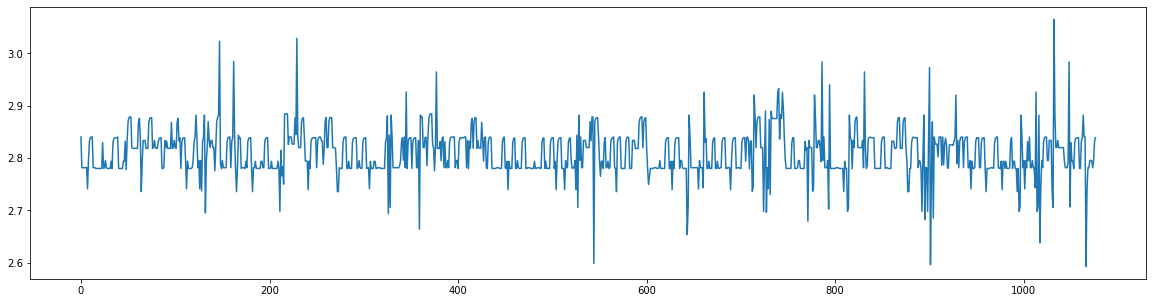

In [51]:
fig = plt.figure(figsize=(20,5))   
plt.plot(rnn_forecast) 
plt.show() 

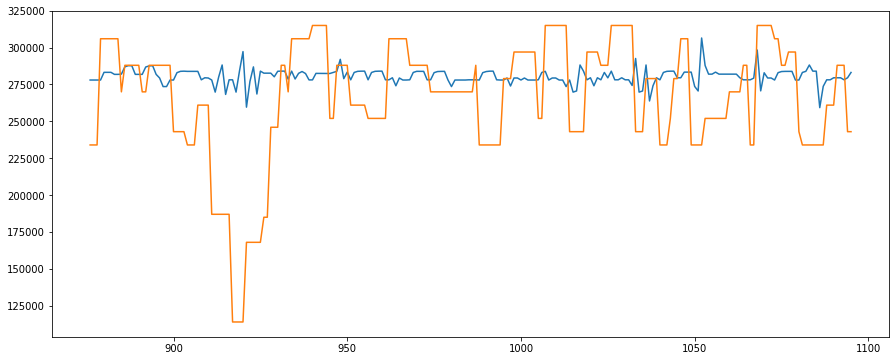

In [52]:
plt.figure(figsize=(15, 6))    
plt.plot(list(range(trainMaxIndex, total_data)), (new_forecast*100000).astype(int)) 
plt.plot(list(range(trainMaxIndex, total_data)), (test_cost*100000).to_numpy().astype(int)) 
plt.show() 

In [53]:
print((new_forecast*100000).astype(int))
print((test_cost*100000).to_numpy().astype(int))

[278015 278015 278015 278015 283226 283226 283226 281853 281853 282000
 286984 287748 287707 281853 281853 281853 286837 287601 287707 281853
 279389 273583 273583 278015 278015 283000 283911 284016 283884 283886
 283886 283886 278162 279536 279389 278015 269822 280084 288210 268255
 278162 278162 269822 284275 297275 259620 277093 286915 268529 284042
 282669 282669 282669 280210 283961 284053 284052 278613 284038 278711
 282552 283780 282406 278085 278098 282519 282517 282521 282522 282441
 283141 283905 292047 278941 283373 278162 283147 283911 284016 284031
 278162 283147 283911 284016 284031 278162 278162 279536 274111 279389
 278015 278015 278162 283147 283911 283869 283884 278162 278162 283000
 283764 283869 283884 278015 273583 278015 278015 278015 278015 278162
 278162 278162 278015 283000 283764 284016 284031 278162 278015 278015
 279389 273964 279389 279389 278015 279389 278015 278015 278015 278162
 283147 283911 278015 279389 279389 278015 278015 273583 278015 269822
 27058

In [54]:
# Menyimpan model dalam format SavedModel
export_dir = 'saved_model/'
tf.saved_model.save(model, export_dir)

INFO:tensorflow:Assets written to: saved_model/assets


INFO:tensorflow:Assets written to: saved_model/assets


In [55]:
model.save("data.h5")

In [56]:
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
converter.target_spec.supported_ops = [
  tf.lite.OpsSet.TFLITE_BUILTINS, # enable TensorFlow Lite ops.
  tf.lite.OpsSet.SELECT_TF_OPS # enable TensorFlow ops.
]
tflite_model = converter.convert()
 
tflite_model_file = pathlib.Path('data.tflite')
tflite_model_file.write_bytes(tflite_model)

113920